In [1]:
import numpy as np
import _pickle as pkl
import torch
import torch.nn as nn
%matplotlib inline 
import matplotlib.pyplot as plt
import os, sys, time
sys.path.append('../..')
from utils import set_seed_torch, rgb2gray, load_vh_models, frame_stack
set_seed_torch(3)
from train import encode
from argparse import Namespace
import json
import gzip
import random

In [2]:
dirname = "/" + os.path.join(os.getcwd().split("/")[1], os.getcwd().split("/")[2])

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
        
args = ObjectView({
 'res': 64,
 'dataset_path': [dirname + '/visual-haptic-dynamics/experiments/data/datasets/{}'
                   .format("vha1_2D_len16_oscxy_withGT_0B7AB071F98942578ABDA66879290F2F.pkl"),
                  dirname + '/visual-haptic-dynamics/experiments/data/datasets/{}'
                   .format("vha2_2D_len16_oscxy_withGT_3502DE81F7C343FB8B57FA92FDECF4DA.pkl"),
                  dirname + '/visual-haptic-dynamics/experiments/data/datasets/{}'
                   .format("vha3_2D_len16_oscxy_withGT_5DB32B21A6AA4E5892D2F6B8F40EF9E6.pkl")
                 ],
 'models_dir': dirname + '/visual-haptic-dynamics/saved_models/{}'
                   .format("vh"),
 'n_pred': 13,
 'n_initial': 2,
#  'dataset_path': [dirname + '/visual-haptic-dynamics/experiments/data/datasets/mit_push/{}'
#                    .format("rng-initial_min-tr2.5_min-rot0.5_len48.pkl")
#                  ],
#  'models_dir': dirname + '/visual-haptic-dynamics/saved_models/{}'
#                    .format("new_rec/rssm/priorexpert_true"),
#  'n_pred': 42,
#  'n_initial': 5,
 'device': 'cuda',
 'n_examples': 32
})

def load_models_dir(models_dir):
    """Load hyperparameters from trained model."""
    dict_of_models = {}
    for filedir in os.listdir(models_dir):
        fullpath = os.path.join(models_dir, filedir)
        if os.path.isdir(fullpath):
            with open(os.path.join(fullpath, 'hyperparameters.txt'), 'r') as fp:
                dict_of_models[fullpath] = Namespace(**json.load(fp))
    return dict_of_models

def is_gz_file(filepath):
    with open(filepath, 'rb') as test_f:
        return test_f.read(2) == b'\x1f\x8b'
    
data = {
#     'img_rgb': [],
    'img_gray': [],
    'haptic': [],
    'arm': [],
    'actions': [],
    'gt_plate_pos': []
}

for dataset_path in args.dataset_path:
    if is_gz_file(dataset_path):
        with gzip.open(dataset_path, 'rb') as f:
            raw_data = pkl.load(f)
    else:
        with open(dataset_path, 'rb') as f:
            raw_data = pkl.load(f)

#     data['img_rgb'].append(torch.from_numpy(raw_data["img"].transpose(0, 1, 4, 2, 3)).int().to(device=args.device))
    data['img_gray'].append(torch.from_numpy(rgb2gray(raw_data['img']).transpose(0, 1, 4, 2, 3)).float().to(device=args.device))
    data['haptic'].append(torch.from_numpy(raw_data['ft']).float().to(device=args.device))
    data['arm'].append(torch.from_numpy(raw_data['arm']).float().to(device=args.device))
    data['actions'].append(torch.from_numpy(raw_data['action']).to(device=args.device).float())
    data['gt_plate_pos'].append(torch.from_numpy(raw_data['gt_plate_pos']).to(device=args.device).float())
data = {k:torch.cat(v, dim=0) for k,v in data.items()}

# Regression Experiments

In [3]:
dict_of_models = load_models_dir(args.models_dir)

def linear_regression(y, X):
    # Add column of 1s for intercept
    X = np.hstack((X, np.ones((X.shape[0], 1))))

    # Solve for parameters of OLS
    out = np.linalg.lstsq(X, y, rcond=None)
    w = out[0]
    res = out[1]

    # Predicted values
    y_hat = X @ w
    return y_hat, res

def nonlinear_regression(model, y, X):
    batch_size = 32
    n = X.shape[0]
    y_hat = np.zeros((n, 2))
    with torch.no_grad():
        for jj in range(0, n, batch_size):
            batch_range = slice(jj, jj + args.n_examples)  
            mb_X = X[batch_range]
            mb_X = torch.from_numpy(mb_X).to(device=args.device)
            mb_y_hat = model(mb_X)
            y_hat[batch_range] = mb_y_hat.detach().cpu().numpy()
    res = np.sum((y_hat - y)**2, axis=0)

    return y_hat, res

def train_model(y, X):
    class MLP(nn.Module):
        def __init__(self, in_dim, out_dim, layer_size=50):
            super(MLP, self).__init__()
            self.layers = nn.Sequential(
                nn.Linear(in_dim, layer_size),
                nn.ReLU(),
                nn.Linear(layer_size, out_dim)
            )

        def forward(self, x):
            x = self.layers(x)
            return x

    with torch.enable_grad():
        model = MLP(in_dim=model_args.dim_z, out_dim=2).to(device=args.device)
        model.train()
        opt = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = torch.nn.MSELoss()
        epochs = 256
        batch_size = 32
        n = y.shape[0]
        dataset_idx = list(range(n))
        res = np.zeros((model_args.dim_z))

        for ii in range(epochs):
            random.shuffle(dataset_idx)
            epoch_loss = []
            for jj in range(0, n, batch_size):
                batch_range = slice(jj, jj + args.n_examples)  
                mb_X = X[dataset_idx[batch_range]]
                mb_y = y[dataset_idx[batch_range]]

                mb_X = torch.from_numpy(mb_X).to(device=args.device)
                mb_y = torch.from_numpy(mb_y).to(device=args.device)

                mb_y_hat = model(mb_X)
                loss = loss_fn(mb_y_hat, mb_y)
                epoch_loss.append(loss.item())
                opt.zero_grad()
                loss.backward()
                opt.step()
            print(f"Epoch {ii + 1} / {epochs}, Loss: {sum(epoch_loss)/len(epoch_loss)}")
    return model

def generate_dataset_prediction(nets, data, model_args):
    with torch.no_grad():
        n = data["gt_plate_pos"].shape[0]
        z_hat = torch.zeros(((args.n_initial + args.n_pred - T), n, model_args.dim_z)).to(device=args.device)

        for ii in range(0, n, args.n_examples):
            batch_range = slice(ii, ii + args.n_examples)  
            test_batch = {k:v[batch_range] for k,v in data.items()}

            # Set up data for batch
            x_img = test_batch[img_key][:, :(args.n_initial + args.n_pred)]
            x_ft = test_batch['haptic'][:, :(args.n_initial + args.n_pred)]
            x_arm = test_batch['arm'][:, :(args.n_initial + args.n_pred)]
            u = test_batch['actions']
            x_i = {}

            # Sequence of initial images
            x_img_i = x_img[:, :args.n_initial]
            x_img_i = frame_stack(x_img_i, frames=T)
            n, l = x_img_i.shape[0], x_img_i.shape[1] 
            x_i["img"] = x_img_i

            # Sequence of extra modalities
            x_ft_i = x_ft[:, :args.n_initial] / model_args.ft_normalization
            x_arm_i = x_arm[:, :args.n_initial]
            u_i = u[:, T:args.n_initial]

            if model_args.context_modality != "none":
                if model_args.context_modality == "joint":
                    x_i["context"] = torch.cat((x_ft_i, x_arm_i), dim=-1)
                elif model_args.context_modality == "ft":
                    x_i["context"] = x_ft_i
                elif model_args.context_modality == "arm":
                    x_i["context"] = x_arm_i

                if model_args.use_context_frame_stack:
                    x_i['context'] = frame_stack(x_i['context'], frames=T)
                else:
                    x_i["context"] = x_i["context"][:, T:]
                x_i["context"] = x_i["context"].transpose(-1, -2)

            x_i = {k:v.reshape(-1, *v.shape[2:]) for k, v in x_i.items()}

            # Encode
            if model_args.use_prior_expert:
                q_z_i, _, _ = encode(nets, model_args, x_i, u_i, device=args.device)
            else:
                q_z_i = encode(nets, model_args, x_i, u_i, device=args.device)

            # Group and prepare for prediction
            q_z_i = {k:v.reshape(n, l, *v.shape[1:]).transpose(1,0) for k, v in q_z_i.items()}
            u = u.transpose(1,0)

            z_hat[0:l, batch_range] = q_z_i["mu"]

            # First run
            z_i, mu_z_i, var_z_i = q_z_i["z"], q_z_i["mu"], q_z_i["cov"]
            u_i = u[(T + 1):(1 + args.n_initial)]
            h_i = None

            # Predict
            for jj in range(0, args.n_pred):
                z_ip1, mu_z_ip1, var_z_ip1, h_ip1 = nets["dyn"](
                    z_t=z_i, 
                    mu_t=mu_z_i, 
                    var_t=var_z_i, 
                    u=u_i, 
                    h_0=h_i, 
                    single=False
                )
                z_hat[jj + l, batch_range] = mu_z_ip1[-1]
                z_i, mu_z_i, var_z_i, h_i = z_ip1[-1:], mu_z_ip1[-1:], var_z_ip1[-1:], h_ip1
                u_i = u[1 + args.n_initial + jj][None]  

        X = z_hat.reshape(-1, *z_hat.shape[2:]).cpu().numpy()
        if np.size(list(data["gt_plate_pos"].shape)) > 3:
            plate_pos = data["gt_plate_pos"][:, T:(args.n_initial + args.n_pred), -1]
        else:
            plate_pos = data["gt_plate_pos"][:, T:(args.n_initial + args.n_pred)]
        y = plate_pos.transpose(0,1).reshape(-1, *plate_pos.shape[2:]).cpu().numpy()
        y = y[:, :2]
    
    return X, y

def generate_dataset_filtering(nets, data, model_args):
    with torch.no_grad():
        n = data["gt_plate_pos"].shape[0]
        z_hat = torch.zeros(((args.n_initial + args.n_pred - T), n, model_args.dim_z)).to(device=args.device)
        # Use a random batch to test
        for ii in range(0, n, args.n_examples):
            batch_range = slice(ii, ii + args.n_examples)  
            test_batch = {k:v[batch_range] for k,v in data.items()}

            # Set up data for batch
            x_img = test_batch[img_key][:, :(args.n_initial + args.n_pred)]
            x_ft = test_batch['haptic'][:, :(args.n_initial + args.n_pred)]
            x_arm = test_batch['arm'][:, :(args.n_initial + args.n_pred)]
            u = test_batch['actions']
            x_i = {}

            # Sequence of initial images
            x_img_i = x_img[:, :args.n_initial + args.n_pred]
            x_img_i = frame_stack(x_img_i, frames=T)
            n, l = x_img_i.shape[0], x_img_i.shape[1] 
            x_i["img"] = x_img_i

            # Sequence of extra modalities
            x_ft_i = x_ft[:, :args.n_initial + args.n_pred] / model_args.ft_normalization
            x_arm_i = x_arm[:, :args.n_initial + args.n_pred]
            u_i = u[:, T:args.n_initial + args.n_pred]

            if model_args.context_modality != "none":
                if model_args.context_modality == "joint":
                    x_i["context"] = torch.cat((x_ft_i, x_arm_i), dim=-1)
                elif model_args.context_modality == "ft":
                    x_i["context"] = x_ft_i
                elif model_args.context_modality == "arm":
                    x_i["context"] = x_arm_i

                if model_args.use_context_frame_stack:
                    x_i['context'] = frame_stack(x_i['context'], frames=T)
                else:
                    x_i["context"] = x_i["context"][:, T:]
                x_i["context"] = x_i["context"].transpose(-1, -2)

            x_i = {k:v.reshape(-1, *v.shape[2:]) for k, v in x_i.items()}

            # Encode
            if model_args.use_prior_expert:
                q_z_i, _, _ = encode(nets, model_args, x_i, u_i, device=args.device)
            else:
                q_z_i = encode(nets, model_args, x_i, u_i, device=args.device)

            q_z_i = {k:v.reshape(n, l, *v.shape[1:]).transpose(1,0) for k,v in q_z_i.items()}

            z_hat[:, batch_range] = q_z_i["mu"]

        X = z_hat.reshape(-1, *z_hat.shape[2:]).cpu().numpy()

        if np.size(list(data["gt_plate_pos"].shape)) > 3:
            plate_pos = data["gt_plate_pos"][:, T:(args.n_initial + args.n_pred), -1]
        else:
            plate_pos = data["gt_plate_pos"][:, T:(args.n_initial + args.n_pred)]

        y = plate_pos.transpose(0,1).reshape(-1, *plate_pos.shape[2:]).cpu().numpy()
        y = y[:, :2]
        
    return X, y

analysis_data = {}
for path, model_args in dict_of_models.items():
    with torch.no_grad():
        analysis_data[path] = {}
        nets = load_vh_models(path=path, args=model_args, mode='eval', device=args.device)

#         if model_args.dim_x[0] == 1:
#             img_key = 'img_gray'
#         elif model_args.dim_x[0] == 3:
#             img_key = 'img_rgb'
        img_key = 'img_gray'

        n_total = data[img_key].shape[0]
        idx = np.arange(n_total)

        with open(os.path.join(path, "val_idx.pkl"), 'rb') as f:
            val_idx = pkl.load(f)
        train_idx = list(np.delete(idx, val_idx))
        
        # Make sure validation and train are unique
        assert (not bool(set(val_idx) & set(train_idx)))

        data_val = {k:v[val_idx] for k,v in data.items()}
        data_train = {k:v[train_idx] for k,v in data.items()}

        T = model_args.frame_stacks

        assert args.n_initial + args.n_pred <= data_val[img_key].shape[1]
        assert args.n_initial > T

#         X_train, y_train = generate_dataset_filtering(nets, data_train, model_args)
#         X_val, y_val = generate_dataset_filtering(nets, data_val, model_args)

        X_train, y_train = generate_dataset_prediction(nets, data_train, model_args)
        X_val, y_val = generate_dataset_prediction(nets, data_val, model_args)

        y_hat, res = linear_regression(y_val, X_val)

#         model = train_model(y_val, X_val)
#         y_hat, res = nonlinear_regression(model, y_val, X_val)

        analysis_data[path]["res"] = res
        analysis_data[path]["y"] = y_val
#         analysis_data[path]["y"] = y_train
        analysis_data[path]["y_hat"] = y_hat

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/vh/1465883_nstep2_reproduce_1024optbase_noAnnealkl_yesWN_noBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_vha_r1.00_kl1.00_lr3e4
Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/vh/1485221_nstep2_1024optbase_noAnnealkl_yesWN_noBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_va_r1.00_kl1.00_lr3e4
Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/vh/1485220_nstep2_1024optbase_noAnnealkl_yesWN_noBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_vh_r1.00_kl1.00_lr3e4
Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/vh/1465882_nstep2_reproduce_1024optbase_noAnnealkl_yesWN_noBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_v_r1.00_kl1.00_lr3e4


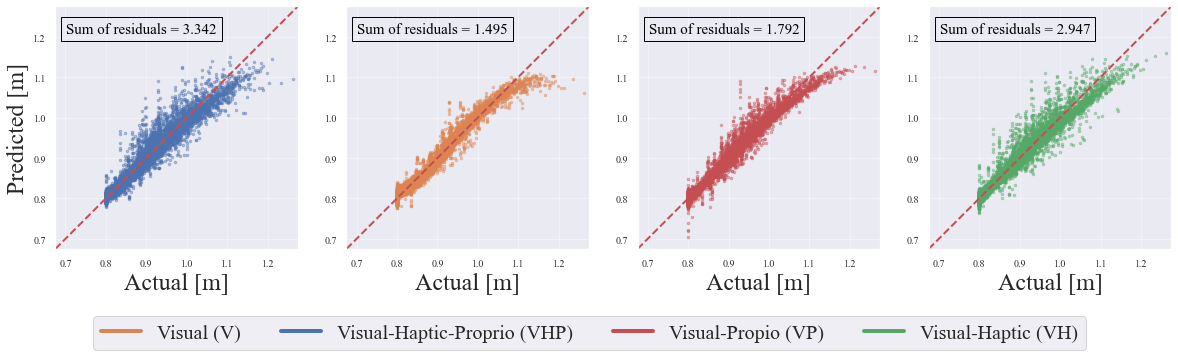

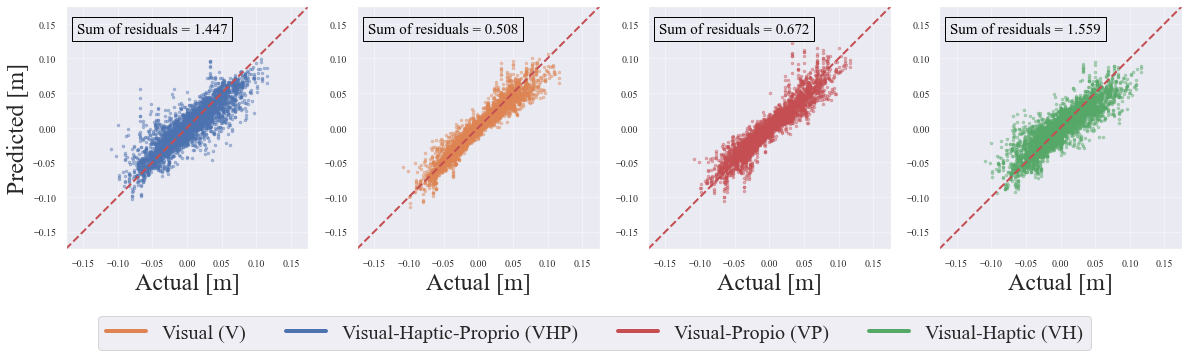

In [4]:
from matplotlib.lines import Line2D
import seaborn as sns
import matplotlib as mpl
sns.set()
mpl.rcParams["xtick.labelsize"] = 10
mpl.rcParams["ytick.labelsize"] = 10
mpl.rcParams["font.family"] = "Times New Roman"
sns.color_palette()

def regression_plot(data):     
    for ii in range(2):
        fig, axs = plt.subplots(1, 4, figsize=(20,6.5))
        for path, v in data.items():
            y = v["y"][:, ii]
            y_hat = v["y_hat"][:, ii]
            res = v["res"]
            
            if "_vha_" in path:
#                 color = '#ff7f0e'
                color = "#DD8452"
                jj=1
            elif "_v_" in path:
#                 color = '#1f77b4'
                color = "#4C72B0"
                jj=0
            elif "_va_" in path:
#                 color = 'red'
                color = "#C44E52"
                jj=2
            elif "_vh_" in path:
#                 color = 'green'
                color = "#55A868"
                jj=3

            axs[jj].plot(y, y_hat, 'o', markersize=2.5, c=color, alpha=0.40)
            axs[jj].grid(alpha=0.35, linestyle='solid', axis='both')
            axs[jj].text(
                0.045, 
                0.89, 
                f"Sum of residuals = {res[ii]:.3f}", 
                size=15,
                color='black', 
                bbox=dict(facecolor='none', edgecolor='black', pad=5.0),
                transform = axs[jj].transAxes
            )
            if "mit" in args.dataset_path[0]:
                if ii == 1:
                    axs[jj].set_xlim((-0.2, 0.2))
                    axs[jj].set_ylim((-0.2, 0.2))
                elif ii == 0:
                    axs[jj].set_xlim((-0.2, 0.2))
                    axs[jj].set_ylim((-0.2, 0.2))
            else:
                if ii == 1:
                    axs[jj].set_xlim((-0.175, 0.175))
                    axs[jj].set_ylim((-0.175, 0.175))
                elif ii == 0:
                    axs[jj].set_xlim((0.675, 1.275))
                    axs[jj].set_ylim((0.675, 1.275))
                
            axs[jj].plot(axs[jj].get_xlim(), axs[jj].get_ylim(), lw=2, ls="--", c="r")
        
        for kk in range(axs.shape[0]):
            axs[kk].set_xlabel('Actual [m]', size=24)
            axs[kk].set_aspect('equal', adjustable='box')
        axs[0].set_ylabel('Predicted [m]', size=24)

        custom_lines = [Line2D([0], [0], color="#DD8452", lw=4),
                        Line2D([0], [0], color="#4C72B0", lw=4),
                        Line2D([0], [0], color="#C44E52", lw=4),
                        Line2D([0], [0], color="#55A868", lw=4)]

        leg = fig.legend(
            custom_lines, 
            ['Visual (V)',
             'Visual-Haptic-Proprio (VHP)',
             'Visual-Propio (VP)',
             'Visual-Haptic (VH)'], 
            loc='lower center',
            fancybox=True,
            shadow=False,
            ncol=4,
            fontsize=20,
        )
        plt.show()
        fig.savefig(f'out/{ii}.pdf')  
        
f = regression_plot(analysis_data)

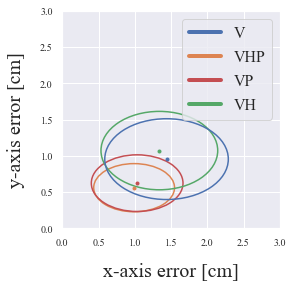

In [5]:
from matplotlib.patches import Ellipse
import seaborn as sns
import matplotlib as mpl

sns.set()
mpl.rcParams["xtick.labelsize"] = 10
mpl.rcParams["ytick.labelsize"] = 10
mpl.rcParams["font.family"] = "Times New Roman"
sns.color_palette()

def ellipse_plot(data):
    fig, axs = plt.subplots()
    for path, v in data.items():
        y = v["y"]
        y_hat = v["y_hat"]
        res = v["res"]

        if "_vha_" in path:
            color = "#DD8452"
        elif "_v_" in path:
            color = "#4C72B0"
        elif "_va_" in path:
            color = "#C44E52"
        elif "_vh_" in path:
            color = "#55A868"
            
        custom_lines = [Line2D([0], [0], color="#4C72B0", lw=4),
                        Line2D([0], [0], color="#DD8452", lw=4),
                        Line2D([0], [0], color="#C44E52", lw=4),
                        Line2D([0], [0], color="#55A868", lw=4)]
        axs.legend(
            custom_lines, 
            ['V',
             'VHP',
             'VP',
             'VH'], 
            loc='upper right',
            fancybox=True,
            shadow=False,
            fontsize=16
        )

        error = 100 * np.abs(y - y_hat)
        mean_error = np.mean(error, axis=0)
        std_error = np.std(error, axis=0)
        
        se = np.sum(error**2, axis=0)
        
        ellipse = Ellipse(
            xy = (mean_error[0], mean_error[1]),
            width = std_error[0],
            height = std_error[1],
            facecolor= "none",
            edgecolor=color,
            linewidth=1.5
        )

        axs.plot(mean_error[0], mean_error[1], ".", color=color)  
        axs.add_patch(ellipse)
        axs.set_aspect('equal', adjustable='box')
        axs.set_xlabel('x-axis error [cm]', size=20, labelpad=15)
        axs.set_ylabel('y-axis error [cm]', size=20, labelpad=15)
        axs.set_xlim((0, 3.00))
        axs.set_ylim((0, 3.00))
        
        fig.savefig(f'out/ellipses_sim.pdf', bbox_inches='tight')  
        
f = ellipse_plot(analysis_data)